# Decision Tree Classification

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset

In [2]:
dataset = pd.read_csv('bank_data_preprocessed.csv')

In [3]:
# The target(s) (dependent variable) is 'log price'
y = dataset['y']

# The inputs are everything BUT the dependent variable, so we can simply drop it
X = dataset.drop(['y'],axis=1)

In [4]:
X.shape

(30360, 47)

## Splitting the dataset into the Training set and Test set

In [5]:
from sklearn.model_selection import train_test_split
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

## Handling imbalanced output

In [6]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [7]:
X_train.shape

(45910, 47)

In [8]:
y_train.shape

(45910,)

In [9]:
y_train.value_counts()

y
0    22955
1    22955
Name: count, dtype: int64

## Feature Scaling

In [10]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = X.columns[:4]
sc = StandardScaler()
X_train[columns_to_scale] = sc.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = sc.transform(X_test[columns_to_scale])
X_train.head()

,age,duration,campaign,cons.conf.idx,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,-0.783377,-1.072651,0.153707,-0.424406,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.394331,-1.167525,1.026412,-0.424406,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.390808,-1.090440,-0.718998,-0.279872,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
3,-0.390808,-0.491546,-0.718998,-1.147077,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
4,0.001761,-0.788028,0.153707,0.938345,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


## Training the Decision Tree Classification model on the Training set

In [11]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

## Model evaluation metrics of training set

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score,precision_score,f1_score
from sklearn.metrics import roc_curve, auc
y_hat = classifier.predict(X_train)
print(f"accuracy {accuracy_score(y_train, y_hat):.4f}")
print(f'recall: {recall_score(y_train, y_hat):.4f}')
print(f'precision: {precision_score(y_train, y_hat):.4f}')
print(f'f1-score: {f1_score(y_train, y_hat):.4f}')

accuracy 1.0000
recall: 1.0000
precision: 1.0000
f1-score: 1.0000


## Find threshold based on Validation dataset

In [13]:
y_valid_pred = classifier.predict(X_valid)
print(f"accuracy {accuracy_score(y_valid, y_valid_pred):.4f}")
print(f'recall: {recall_score(y_valid, y_valid_pred):.4f}')
print(f'precision: {precision_score(y_valid, y_valid_pred):.4f}')
print(f'f1-score: {f1_score(y_valid, y_valid_pred):.4f}')

accuracy 0.6103
recall: 0.2229
precision: 0.0339
f1-score: 0.0589


In [14]:
y_valid_prob = classifier.predict_proba(X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_prob)

In [15]:
# Find the threshold that maximizes the Youden's J statistic (sensitivity + specificity - 1)
Youden_J = tpr - fpr
# Avoid division by zero by setting Youden_J to zero where fpr is zero
Youden_J_without_inf = np.where(fpr == 0, 0, Youden_J)

best_threshold_index = np.argmax(Youden_J_without_inf)
best_threshold = thresholds[best_threshold_index]
if best_threshold >= 1:
    best_threshold = 0.9
elif best_threshold <= 0.02:
    best_threshold = 0.02
print(f"Best Threshold: {best_threshold}")
# Convert probabilities to binary predictions based on the threshold
y_valid_pred = (y_valid_prob > best_threshold).astype(int)

# Evaluate the model performance
print(f'With threshold {best_threshold:.4f} found best from roc of validation set:')
print(f"accuracy {accuracy_score(y_valid, y_valid_pred):.4f}")
print(f'recall: {recall_score(y_valid, y_valid_pred):.4f}')
print(f'precision: {precision_score(y_valid, y_valid_pred):.4f}')
print(f'f1-score: {f1_score(y_valid, y_valid_pred):.4f}')

Best Threshold: 0.9
With threshold 0.9000 found best from roc of validation set:
accuracy 0.6103
recall: 0.2229
precision: 0.0339
f1-score: 0.0589


## Predicting the Test set results

In [16]:
y_prob = classifier.predict_proba(X_test)[:, 1]
y_pred = classifier.predict(X_test)

## Model Evaluation Metrics on test set

In [17]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(cm)
print(f'accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'recall: {recall_score(y_test, y_pred):.4f}')
print(f'precision: {precision_score(y_test, y_pred):.4f}')
print(f'f1-score: {f1_score(y_test, y_pred):.4f}')
print(f'auc: {roc_auc:.4f}')

[[2766  114]
 [  92   64]]
accuracy: 0.9321
recall: 0.4103
precision: 0.3596
f1-score: 0.3832
auc: 0.6853


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2880
           1       0.36      0.41      0.38       156

    accuracy                           0.93      3036
   macro avg       0.66      0.69      0.67      3036
weighted avg       0.94      0.93      0.93      3036



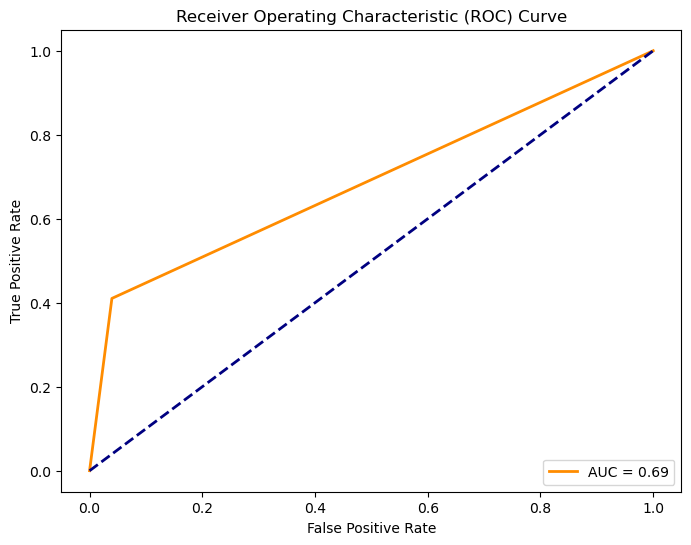

In [19]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Model Evaluation Metrics on test set based on validation threshold

In [20]:
y_prob

array([0., 0., 0., ..., 0., 0., 0.])

In [21]:
y_pred_threshold_adjusted = (y_prob > best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_threshold_adjusted)
# Evaluate the model performance
print(f'With threshold {best_threshold:.4f} from validation data:')
print(cm)
print(f"accuracy {accuracy_score(y_test, y_pred_threshold_adjusted):.4f}")
print(f'recall: {recall_score(y_test, y_pred_threshold_adjusted):.4f}')
print(f'precision: {precision_score(y_test, y_pred_threshold_adjusted):.4f}')
print(f'f1-score: {f1_score(y_test, y_pred_threshold_adjusted):.4f}')

With threshold 0.9000 from validation data:
[[2766  114]
 [  92   64]]
accuracy 0.9321
recall: 0.4103
precision: 0.3596
f1-score: 0.3832


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_threshold_adjusted))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2880
           1       0.36      0.41      0.38       156

    accuracy                           0.93      3036
   macro avg       0.66      0.69      0.67      3036
weighted avg       0.94      0.93      0.93      3036

